# Studying Wikipedia Page Protections
This notebook provides a tutorial for how to study [page protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy) on Wikipedia either via the [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) or [API](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo). It has three stages:
* Accessing the Page Protection dumps
* Accessing the Page Protection API
* Example analysis of page protection data (both descriptive statistics and learning a predictive model)

## Accessing the Page Protection Dumps
This is an example of how to parse through [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) and determine [what sorts of edit protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy#Overview_of_types_of_protection) are applied to a given Wikipedia article.

In [1]:
# TODO: add other libraries here as necessary
import gzip  # necessary for decompressing dump file into text format
import pandas as pd #for data manipulation and analysis
import numpy as np #for mathematical calculations  
import seaborn as sns #visualization tool
import os   #for interacting with operating system
from sklearn.preprocessing import LabelEncoder, MinMaxScaler #for replacing categorical data with a numerical data
from scipy import stats #for statistical functions
import re #for sequence of character and string 


In [2]:
# Every language on Wikipedia has its own page restrictions table
# you can find all the dbnames (e.g., enwiki) here: https://www.mediawiki.org/w/api.php?action=sitematrix
# for example, you could replace the LANGUAGE parameter of 'enwiki' with 'arwiki' to study Arabic Wikipedia
LANGUAGE = 'enwiki'
# e.g., enwiki -> en.wikipedia (this is necessary for the API section)
SITENAME = LANGUAGE.replace('wiki', '.wikipedia')
# directory on PAWS server that holds Wikimedia dumps
DUMP_DIR = "/public/dumps/public/{0}/latest/".format(LANGUAGE)
DUMP_FN = '{0}-latest-page_restrictions.sql.gz'.format(LANGUAGE)

In [3]:
# The dataset isn't huge -- 1.1 MB -- so should be quick to process in full
!ls -shH "{DUMP_DIR}{DUMP_FN}"

1.1M /public/dumps/public/enwiki/latest/enwiki-latest-page_restrictions.sql.gz


In [4]:
# Inspect the first 1000 characters of the page protections dump to see what it looks like
# As you can see from the CREATE TABLE statement, each datapoint has 7 fields (pr_page, pr_type, ... , pr_id)
# A description of the fields in the data can be found here:
#   https://www.mediawiki.org/wiki/Manual:Page_restrictions_table
# And the data that we want is on lines that start with INSERT INTO `page_restrictions` VALUES...
# The first datapoint (1086732,'edit','sysop',0,NULL,'infinity',1307) can be interpreted as:
#   1086732:    page ID 1086732 (en.wikipedia.org/wiki/?curid=1086732)
#   'edit':     has edit protections
#   'sysop':    that require sysop permissions (https://en.wikipedia.org/wiki/Wikipedia:User_access_levels#Administrator)
#   0:          does not cascade to other pages
#   NULL:       no user-specific restrictions
#   'infinity': restriction does not expire automatically
#   1307:       table primary key -- has no meaning by itself

!zcat "{DUMP_DIR}{DUMP_FN}" | head -46 | cut -c1-1000

-- MySQL dump 10.16  Distrib 10.1.45-MariaDB, for debian-linux-gnu (x86_64)
--
-- Host: 10.64.48.13    Database: enwiki
-- ------------------------------------------------------
-- Server version	10.1.43-MariaDB

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;

--
-- Table structure for table `page_restrictions`
--

DROP TABLE IF EXISTS `page_restrictions`;
/*!40101 SET @saved_cs_client     = @@character_set_client */;
/*!40101 SET character_set_c

In [5]:
# TODO: Complete example that loops through all page restrictions in the dump file above and extracts data
# The Python gzip library will allow you to decompress the file for reading: https://docs.python.org/3/library/gzip.html#gzip.open
#Data Extraction with gzip, for loop, statement and regex. 

Mediawiki= []
with gzip.open(os.path.join(DUMP_DIR, DUMP_FN), 'r') as val:
    for values in val.readlines():
        if values.startswith(b'INSERT INTO `page_restrictions` VALUES'):
            #The spliting on parentheses and then comma is solely for this data. It wouldnt be applicable if the data contains these characters in it itself 
            collections= re.findall(b'\((.*?)\)',values)
            Mediawiki.extend(collections)         


In [6]:
#for lines in Mediawiki:
    #lines.decode(encoding='UTF-8',errors='ignore').split(',')

#Turning the comma separated list to a DataFrame    
MediaWiki= pd.DataFrame((lines.decode(encoding='UTF-8',errors='ignore').split(',') for lines in Mediawiki), columns=['page_id', 'types_of_protection', 'levels_of_protection', 'cascading', 'per_user', 'expirations','foreign_key'])
MediaWiki.head(10)     

,page_id,types_of_protection,levels_of_protection,cascading,per_user,expirations,foreign_key
0,1086732,'edit','sysop',0,NULL,'infinity',1307
1,1086732,'move','sysop',0,NULL,'infinity',1308
2,1266562,'edit','autoconfirmed',0,NULL,'infinity',1358
3,1266562,'move','autoconfirmed',0,NULL,'infinity',1359
4,1534334,'edit','autoconfirmed',0,NULL,NULL,1437
5,1534334,'move','autoconfirmed',0,NULL,NULL,1438
6,1654125,'edit','autoconfirmed',0,NULL,NULL,1664
7,1654125,'move','autoconfirmed',0,NULL,NULL,1665
8,1654622,'edit','autoconfirmed',0,NULL,NULL,1672
9,1654622,'move','autoconfirmed',0,NULL,NULL,1673


## Accessing the Page Protection APIs
The [Page Protection API](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo) can be a much simpler way to access data about page protections for a given article if you know what articles you are interested in and are interested in relatively few articles (e.g., hundreds or low thousands).

NOTE: the APIs are up-to-date while the Mediawiki dumps are always at least several days behind -- i.e. for specific snapshots in time -- so the data you get from the Mediawiki dumps might be different from the APIs if permissions have changed to a page's protections in the intervening days.

In [7]:
# TODO: add other libraries here as necessary
import mwapi  # useful for accessing Wikimedia API
import random #python module for generating data randomly


In [8]:
# TODO: Gather ten random page IDs from the data gathered from the Mediawiki dump to get data for from the API
rand_id= random.sample(list(MediaWiki['page_id']) ,10) 
ten_mediawiki= MediaWiki[MediaWiki['page_id'].isin(rand_id)].set_index('page_id') 


In [9]:
ten_mediawiki.index= ten_mediawiki.index.astype(int) #change from string to integer 
ten_mediawiki.sort_index()

,types_of_protection,levels_of_protection,cascading,per_user,expirations,foreign_key
page_id,,,,,,
581018,'edit','extendedconfirmed',0,NULL,'infinity',851555
3887612,'move','templateeditor',0,NULL,'infinity',509366
3887612,'edit','templateeditor',0,NULL,'infinity',509365
17250697,'edit','autoconfirmed',0,NULL,'infinity',118750
17250697,'move','autoconfirmed',0,NULL,'infinity',118751
19507416,'move','sysop',0,NULL,'infinity',794058
19507416,'edit','sysop',0,NULL,'infinity',794057
19940811,'edit','templateeditor',0,NULL,'infinity',565232
19940811,'move','templateeditor',0,NULL,'infinity',565233


In [10]:
# mwapi documentation: https://pypi.org/project/mwapi/
# user_agent helps identify the request if there's an issue and is best practice
tutorial_label = 'Page Protection API tutorial (mwapi)'
# NOTE: it is best practice to include a contact email in user agents
# generally this is private information though so do not change it to yours
# if you are working in the PAWS environment or adding to a Github repo
# for Outreachy, you can leave this as my (isaac's) email or switch it to your Mediawiki username
# e.g., Isaac (WMF) for https://www.mediawiki.org/wiki/User:Isaac_(WMF)
contact_email = 'isaac@wikimedia.org'
session = mwapi.Session('https://{0}.org'.format(SITENAME), user_agent='{0} -- {1}'.format(tutorial_label, contact_email))

# TODO: You'll have to add additional parameters here to query the pages you're interested in
# API endpoint: https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo
# More details: https://www.mediawiki.org/wiki/API:Info
params = {'action':'query',
          'inprop': 'protection',
          'pageids': "|".join(rand_id),
          'intestactionsdetail': 'boolean',
          'prop':'info'}


In [11]:
# TODO: make request to API for data
req= session.get(params)

In [12]:
request= req['query']['pages']
request= pd.DataFrame(request).T

In [13]:
# TODO: examine API results and compare to data from Mediawiki dump to see if they are the same and explain any discrepancies
variable= request['protection']
index= request['pageid'].reset_index(drop= True, level=0)
venus= [pd.DataFrame(i) for i in variable]
#Turning the protection data to a dataframe for us to compare them easily
prot_data= pd.concat(venus, keys= index, axis= 0)
prot_data

type              level    expiry  \
pageid                                          
581018   0  edit  extendedconfirmed  infinity   
3887612  0  edit     templateeditor  infinity   
         1  move     templateeditor  infinity   
17250697 0  edit      autoconfirmed  infinity   
         1  move      autoconfirmed  infinity   
19507416 0  edit              sysop  infinity   
         1  move              sysop  infinity   
         2  edit              sysop  infinity   
19940811 0  edit     templateeditor  infinity   
         1  move     templateeditor  infinity   
20204644 0  edit              sysop  infinity   
         1  move              sysop  infinity   
21194417 0  move              sysop  infinity   
22911343 0  edit              sysop  infinity   
         1  move              sysop  infinity   
43448771 0  edit      autoconfirmed  infinity   
         1  move              sysop  infinity   
55833842 0  edit      autoconfirmed  infinity   
         1  move      autoconfirmed  infinity   

                                               source  
pageid                                                 
581018   0                                        NaN  
3887612  0                                        NaN  
         1                                        NaN  
17250697 0                                        NaN  
         1                                        NaN  
19507416 0                                        NaN  
         1                                        NaN  
         2  Wikipedia:Cascade-protected items/content  
19940811 0                                        NaN  
         1                                        NaN  
20204644 0                                        NaN  
         1                                        NaN  
21194417 0                                        NaN  
22911343 0                                        NaN  
         1                                        NaN  
43448771 0                                        NaN  
         1                                        NaN  
55833842 0                                        NaN  
         1                                        NaN

From the comparison of both the API and the MEDIAWIKI Dump file, I've been able to deduce that;

1. They both contain the same data and info
2. The API Data has more current information than the Mediawiki data which is seen to be behind. However, looking from the page id 8778099, the API Data contain duplicate values as well


## Example Analyses of Page Protection Data
Here we show some examples of things we can do with the data that we gathered about the protections for various Wikipedia articles. You'll want to come up with some questions to ask of the data as well. For this, you might need to gather additional data such as:
* The [page table](https://www.mediawiki.org/wiki/Manual:Page_table), which, for example, can be found in the `DUMP_DIR` under the name `{LANGUAGE}-latest-page.sql.gz`
* Selecting a sample of, for example, 100 articles and getting additional information about them from other [API endpoints](https://www.mediawiki.org/wiki/API:Properties).

In [14]:
# TODO: add any imports of data analysis / visualization libraries here as necessary
import seaborn as sns #for visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

DUMP_DIR= "/public/dumps/public/{0}/latest/".format(LANGUAGE)
PG_TABLE= "{0}-latest-page.sql.gz".format(LANGUAGE)

In [15]:
!zcat "{DUMP_DIR}{PG_TABLE}" | head -40 | cut -c1-3000


gzip: stdout: Broken pipe
-- MySQL dump 10.16  Distrib 10.1.45-MariaDB, for debian-linux-gnu (x86_64)
--
-- Host: 10.64.48.13    Database: enwiki
-- ------------------------------------------------------
-- Server version	10.1.43-MariaDB

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;

--
-- Table structure for table `page`
--

DROP TABLE IF EXISTS `page`;
/*!40101 SET @saved_cs_client     = @@character_set_client */;
/*!40101 SET character_set_

## Quering More Data for the Protected PageID


In other to make better analysis, we are using random samples generated from the Mediawiki data to query more API pages   

In [16]:
def more_ids(page, properties):
    
    #Here we are reducing the list of page ids to be queried to 50 because that is the ideal number that can be queried at once
    page_reduce = [page[x:x + 50] for x in range(0, len(page),50)] 
    
    All= {} #setting all to an empty dictionary
    
    #Here we loop through eavh of the 50 page ids
    for pages in page_reduce:
        parameters= {"action":"query",
                     "inprop": properties,
                     "prop": "info",
                     "pageids":'|'.join(map(str, pages)),
                    }

        
        data= session.get(parameters)
        
        #The queried data is been added to the All empty dict
        All.update(data['query']['pages'])
        
    return All

#Here we queried API for more data on each of these pages separated by "|"
properties= "watched|protection|visitingwatchers|talkid|watchers|subjectid"

In [17]:
#generate data randomly  from the mediawiki

series = pd.Series(MediaWiki.page_id)
rand_gen= series.sample(1000, random_state=42).values
req_data =more_ids(rand_gen, properties)

#Transforming into a dataframe
protection_data = pd.DataFrame(req_data).T

### Descriptive statistics
TODO: give an overview of basic details about page protections and any conclusions you reach based on the analyses you do below

Detailed Analysis of Our Data

In [18]:
# TODO: do basic analyses here to understand the data
protection_data.head()

,pageid,missing,ns,title,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,protection,restrictiontypes,watchers,visitingwatchers,talkid,redirect,subjectid,new
28161281,28161281,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20778,20778,NaN,0,Misandry,wikitext,en,en,ltr,2020-10-30T17:07:04Z,985890230,27587,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",373,34,47175,NaN,NaN,NaN
1207714,1207714,NaN,4,"Wikipedia:Today's featured article/November 8,...",wikitext,en,en,ltr,2020-05-16T16:11:26Z,27104891,1525,"[{'type': 'edit', 'level': 'sysop', 'expiry': ...","[edit, move]",NaN,NaN,NaN,NaN,NaN,NaN
1426343,1426343,NaN,0,Apostolic Lutheran Church of America,wikitext,en,en,ltr,2020-10-13T18:41:23Z,983347921,6617,"[{'type': 'edit', 'level': 'autoconfirmed', 'e...","[edit, move]",NaN,NaN,2352893,NaN,NaN,NaN
1431859,1431859,NaN,10,Template:Pp-main-page,wikitext,en,en,ltr,2020-10-05T08:35:57Z,778048312,44,"[{'type': 'edit', 'level': 'sysop', 'expiry': ...","[edit, move]",NaN,NaN,3975907,,NaN,NaN


In [19]:
#Since the protection variable is seen to comprise of values in ditionaries 
#This is done to separate each of the properties into a DataFrame
protect_data= protection_data.dropna(subset=['protection'])
men= protect_data['protection']
ind= protect_data['pageid']
mass= [pd.DataFrame(x) for x in men]
df= pd.concat(mass, keys= ind).reset_index(level= 1, drop= True)

#Joining the newly acquired dataframe of the protection column to the aforementioned dataframe
df = protection_data.set_index('pageid').join(df)
#To drop the protection variable since t has been expanded
df.drop(['protection'], axis= 1, inplace= True)
df.head()


,missing,ns,title,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,...,watchers,visitingwatchers,talkid,redirect,subjectid,new,type,level,expiry,source
pageid,,,,,,,,,,,,,,,,,,,,,
620,NaN,0,Animal Farm,wikitext,en,en,ltr,2020-10-30T03:41:58Z,986084052,72645,...,582,56,182359,NaN,NaN,NaN,edit,autoconfirmed,infinity,NaN
620,NaN,0,Animal Farm,wikitext,en,en,ltr,2020-10-30T03:41:58Z,986084052,72645,...,582,56,182359,NaN,NaN,NaN,move,sysop,infinity,NaN
2187,NaN,0,Antisemitism in the Arab world,wikitext,en,en,ltr,2020-10-29T19:53:46Z,984346437,55458,...,177,NaN,3069,NaN,NaN,NaN,edit,extendedconfirmed,infinity,NaN
2187,NaN,0,Antisemitism in the Arab world,wikitext,en,en,ltr,2020-10-29T19:53:46Z,984346437,55458,...,177,NaN,3069,NaN,NaN,NaN,move,extendedconfirmed,infinity,NaN
2417,NaN,0,Alicante,wikitext,en,en,ltr,2020-10-30T16:53:25Z,979201708,45906,...,102,NaN,851735,NaN,NaN,NaN,move,sysop,infinity,NaN


In [20]:
#Note: 'df' is the dataframe containing all the expanded protection data

In [21]:
protection_data.shape
#Before exanding, there are 19 columns and 999 rows

(999, 19)

In [22]:
df.shape
# After expanding, there are now 21 columns 1916 rows

(1916, 21)

In [23]:
df['type'].dropna()
df.type.value_counts()
#This is to drop all missing values in "protection type" varable since it is our target values

edit      951
move      941
upload      1
Name: type, dtype: int64

In [24]:
protection_data.isnull().sum()

pageid                    0
missing                 980
ns                       19
title                    19
contentmodel             19
pagelanguage             19
pagelanguagehtmlcode     19
pagelanguagedir          19
touched                  19
lastrevid                19
length                   19
protection               19
restrictiontypes         19
watchers                758
visitingwatchers        902
talkid                  389
redirect                786
subjectid               937
new                     931
dtype: int64

In [25]:
df.isnull().sum()

missing                 1897
ns                        19
title                     19
contentmodel              19
pagelanguage              19
pagelanguagehtmlcode      19
pagelanguagedir           19
touched                   19
lastrevid                 19
length                    19
restrictiontypes          19
watchers                1483
visitingwatchers        1737
talkid                   739
redirect                1493
subjectid               1803
new                     1777
type                      23
level                     23
expiry                    23
source                  1908
dtype: int64

In [26]:
protection_data.fillna(0, inplace= True)


In [27]:
protection_data.dtypes
#The data comprises of both object data types and integers

pageid                   int64
missing                 object
ns                       int64
title                   object
contentmodel            object
pagelanguage            object
pagelanguagehtmlcode    object
pagelanguagedir         object
touched                 object
lastrevid                int64
length                   int64
protection              object
restrictiontypes        object
watchers                 int64
visitingwatchers         int64
talkid                   int64
redirect                object
subjectid                int64
new                     object
dtype: object

In [28]:
df.dtypes

missing                 object
ns                      object
title                   object
contentmodel            object
pagelanguage            object
pagelanguagehtmlcode    object
pagelanguagedir         object
touched                 object
lastrevid               object
length                  object
restrictiontypes        object
watchers                object
visitingwatchers        object
talkid                  object
redirect                object
subjectid               object
new                     object
type                    object
level                   object
expiry                  object
source                  object
dtype: object

In [29]:
protection_data.describe()

,pageid,ns,lastrevid,length,watchers,visitingwatchers,talkid,subjectid
count,9.990000e+02,999.000000,9.990000e+02,999.000000,999.000000,999.000000,9.990000e+02,9.990000e+02
mean,2.388549e+07,25.564565,7.631248e+08,19129.963964,63.601602,7.431431,1.520574e+07,1.523178e+06
std,1.838382e+07,128.809500,2.634627e+08,48279.395244,214.070240,33.315866,1.921035e+07,7.407482e+06
min,6.200000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,7.402048e+06,0.000000,6.631528e+08,85.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,2.165176e+07,3.000000,8.505089e+08,753.000000,0.000000,0.000000,4.277536e+06,0.000000e+00
75%,3.788918e+07,10.000000,9.683788e+08,10901.000000,0.000000,0.000000,2.794054e+07,0.000000e+00
max,6.559759e+07,829.000000,9.862455e+08,676131.000000,2407.000000,680.000000,6.557208e+07,5.882830e+07


* From the decription above:
* There are 999 page ids in this data. 
* The maximum namespace i 829 meaning module talk from the namespace documentation
* The max length an article, pertaining to this data, can have is 676131
* The max number of watcher a page can have is 2407 watchers with 680 visiting watchers as the maximum as well

#### Note: This is just a statistical description of the numerical variables

*All minimum values are seen to be 0. 
*Meaning, 'no article', '0 watchers', '0 visiting watchers'

In [30]:
correlate= protection_data.corr()
correlate

,pageid,ns,lastrevid,length,watchers,visitingwatchers,talkid,subjectid
pageid,1.000000,0.172347,0.089390,-0.185977,-0.183935,-0.062536,0.383394,0.114842
ns,0.172347,1.000000,0.092501,-0.031093,-0.056889,-0.041520,0.092210,0.180596
lastrevid,0.089390,0.092501,1.000000,0.203992,0.208265,0.065860,0.216255,-0.051551
length,-0.185977,-0.031093,0.203992,1.000000,0.515699,0.305938,-0.114842,-0.008436
watchers,-0.183935,-0.056889,0.208265,0.515699,1.000000,0.618848,-0.083639,-0.046828
visitingwatchers,-0.062536,-0.041520,0.065860,0.305938,0.618848,1.000000,-0.068263,-0.020419
talkid,0.383394,0.092210,0.216255,-0.114842,-0.083639,-0.068263,1.000000,-0.162925
subjectid,0.114842,0.180596,-0.051551,-0.008436,-0.046828,-0.020419,-0.162925,1.000000


* From the correlation of the  numerical variables, we can see that
* There is a positive correlation between articles lengths and the number of watchers. Meaning, the longer the page is the higher the number of watchers
* Positive correlation as well between watchers and the visiting watchers 

### Visualizing the length data

<AxesSubplot:>

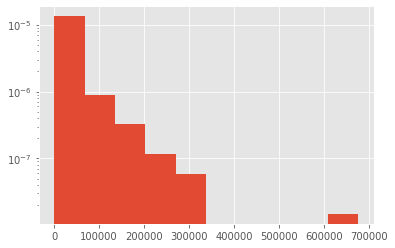

In [31]:
protection_data['length'].hist(log= True, density= True) 

* The length is seen to be right skewed 

### Visualizing the Watcher Variable

<AxesSubplot:>

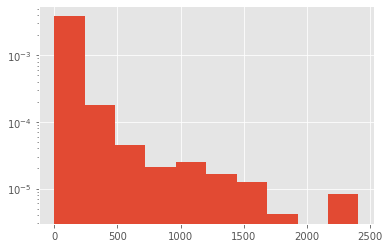

In [32]:
protection_data['watchers'].hist(log= True, density= True) 

* The watchers is seen to be right skewed too

### Visualizing the Visiting Watcher Variable

<AxesSubplot:>

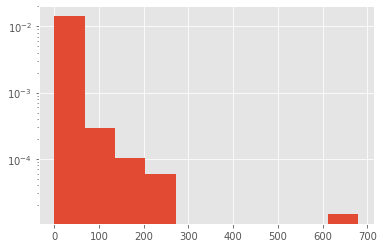

In [33]:
protection_data['visitingwatchers'].hist(log= True, density= True) 

##### Checking Correlation with Pearson

* Right skewed too

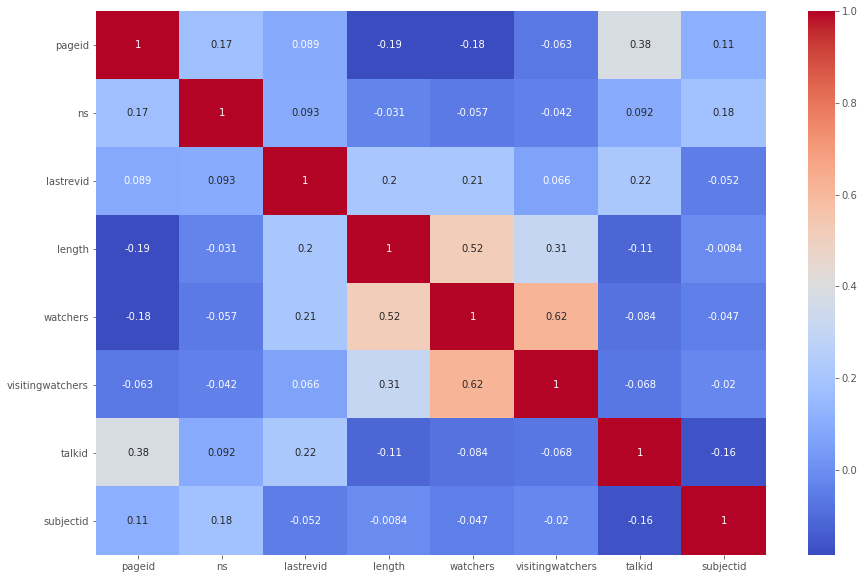

In [34]:
plt.figure(figsize=(15, 10))
sns.heatmap(protection_data.corr(),annot=True,cmap= 'coolwarm') 
plt.show()


* The correlation here have been explained above. This is to make more appealing to the eye 

### Content Model Visualzation

In [35]:
protection_data.contentmodel.value_counts()

wikitext         960
0                 19
Scribunto         17
sanitized-css      2
javascript         1
Name: contentmodel, dtype: int64

<AxesSubplot:xlabel='contentmodel', ylabel='count'>

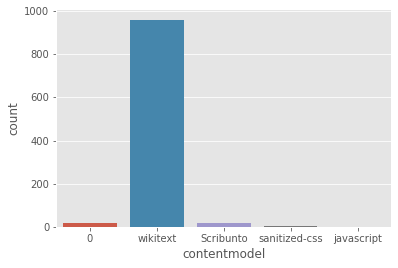

In [36]:
sns.countplot(x=  protection_data['contentmodel'])

* In the cotentmodel variable, wikitext is the most seen among all 

### Protection  Level Visualization

In [37]:
df['level'].value_counts()

autoconfirmed        910
sysop                672
templateeditor       252
extendedconfirmed     59
Name: level, dtype: int64

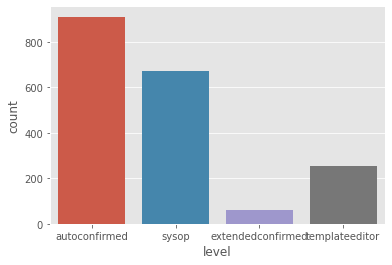

In [38]:
sns.countplot(x= df['level'])
plt.show()

* Talking about the protection level, most of them are autoconfirmed, down to sysop....

<AxesSubplot:ylabel='level'>

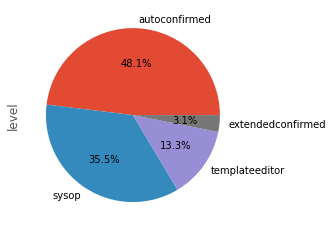

In [39]:
df['level'].value_counts().plot.pie(autopct='%1.1f%%')

* With pie chart, we can see that 48.1% of the levels are autoconfirmed, 35.5% are sysop 

###  Protection Type Visualization

In [40]:
df['type'].value_counts()

edit      951
move      941
upload      1
Name: type, dtype: int64

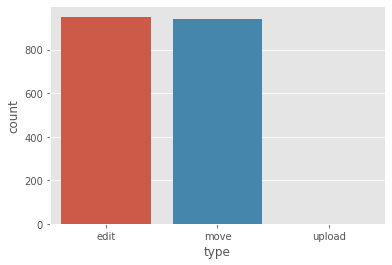

In [41]:
sns.countplot(x= df['type'])
plt.show()

<AxesSubplot:ylabel='type'>

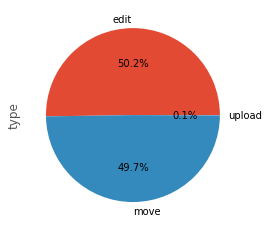

In [42]:
df['type'].value_counts().plot.pie(autopct='%1.1f%%')

* From the Protection type visuals, 50.2% of the pages exhibit the edit protection type while 49.7% exhibit the move type, 0.1 are upload type

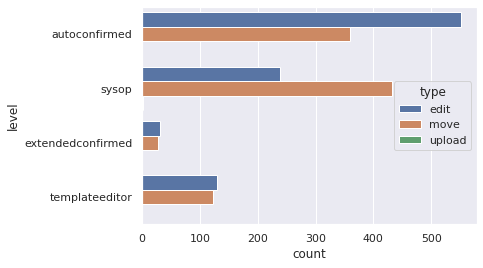

In [43]:
sns.set(style= 'darkgrid')
sns.countplot(y= 'level', hue= 'type', data= df)
plt.show()

#Most sysop level exhibit the move protection type, likewise the rest of the levels

In [44]:
df['expiry'].value_counts()

infinity                1825
2022-06-03T03:07:56Z       2
2021-01-19T22:52:31Z       2
2024-03-30T19:08:36Z       2
2021-03-14T19:48:38Z       2
2021-08-10T02:48:14Z       2
2021-02-25T17:09:47Z       2
2020-11-13T19:36:48Z       2
2021-07-03T14:50:22Z       2
2021-06-25T00:53:53Z       2
2022-05-02T07:27:48Z       2
2021-02-02T11:56:35Z       2
2021-04-23T21:01:22Z       2
2020-11-02T06:31:17Z       2
2022-08-14T20:07:09Z       2
2022-04-20T16:58:13Z       2
2021-01-21T03:40:01Z       2
2025-08-25T11:21:05Z       2
2020-12-21T15:51:26Z       2
2021-01-18T12:29:36Z       2
2021-03-25T19:14:07Z       2
2020-11-07T02:36:22Z       2
2021-03-13T23:38:51Z       2
2023-01-28T18:50:05Z       2
2020-12-15T15:45:25Z       2
2022-04-19T06:16:03Z       2
2021-08-25T08:11:47Z       2
2021-02-10T17:41:35Z       2
2021-03-12T01:47:50Z       2
2021-06-02T20:35:25Z       2
2020-11-23T17:20:45Z       1
2022-05-09T05:41:42Z       1
2021-01-25T02:37:23Z       1
2022-12-28T05:16:47Z       1
2020-12-12T22:

* Mostly, the pages have infinity protection expiry  

### The Namespace Analysis

In [45]:
protection_data.ns.value_counts()

10     358
0      271
2      143
3       93
4       80
828     20
5       11
1        8
829      5
12       3
11       2
118      1
100      1
15       1
9        1
6        1
Name: ns, dtype: int64

* Here, we can see that, most of the pages are of namespace id 10,with the name 'Template', the next is id 0, which is known as 'Main', with the rest thereafter 
* The id to namespace name mapping will bw shown below

In [46]:
PV= protection_data.groupby('ns').sum().reset_index()

In [47]:
PV

,ns,pageid,lastrevid,length,watchers,visitingwatchers,talkid,subjectid
0,0,5415149041,229545782096,11337973,49065,4173,4965276410,0
1,1,99429796,7385693424,174000,2399,253,0,61848760
2,2,4009843109,91936900260,847153,2359,368,1713443981,0
3,3,2556974085,57733254426,4260927,5731,1866,0,863379049
4,4,1684000756,45644333298,1376553,2192,345,744372077,0
5,5,385884378,7550667885,109229,136,136,0,258157134
6,6,8778001,771279707,157,0,0,0,0
7,9,35808529,854208694,23284,0,0,0,0
8,10,8317101858,290793815125,617684,980,152,6963832727,0
9,11,64599331,1699067098,16644,70,0,0,62851402


<AxesSubplot:ylabel='ns'>

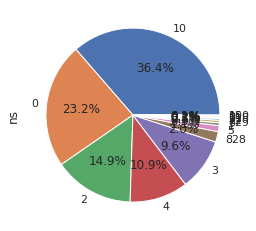

In [48]:
df.ns.value_counts().plot.pie(autopct='%1.1f%%')

* A pie plot necessary for proper visuals, follows the explaination above 

In [49]:
ns_dict= {0:"Main", 1: "Talk", 2:"User", 3:"User Talk", 4: "Project", 5:"Project Talk", 6: "File",9: "Mediawiki-Talk", 10: "Template", 11: "Template Talk", 12: "Help", 15: "Category_Talk",
             100: "Relation", 118: "draft", 828: "Module", 829: "Module Talk"}

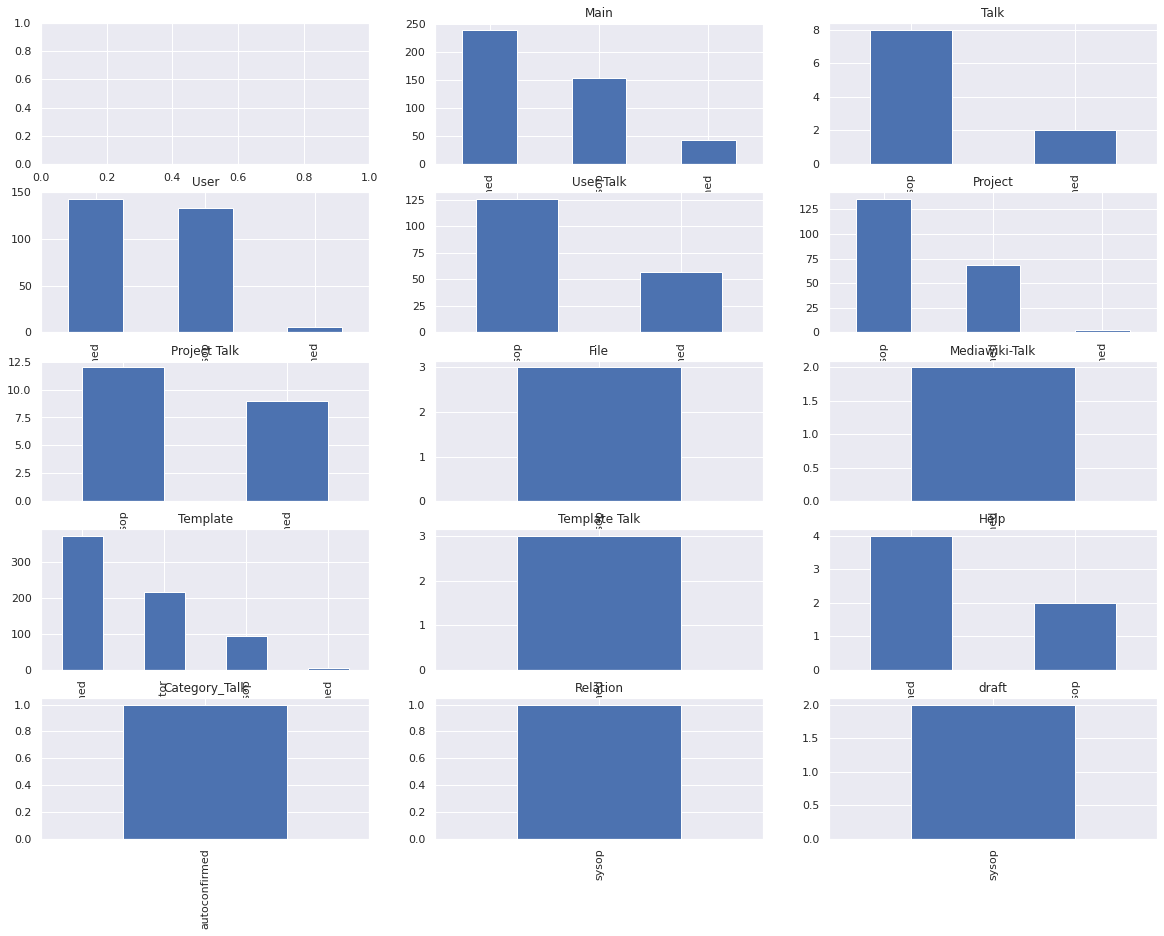

In [50]:
fig, axes = plt.subplots(5,3, figsize=(20,15))

unique= np.unique(protection_data.ns)

for i, ax in enumerate(axes.flatten()[1:]):
    values = df[df['ns']==unique[i]]['level'].value_counts()
    values.plot.bar(ax=ax)
    ax.set_title(ns_dict[int(unique[i])])
    ax.set_ylabel('')

plt.show()



#### From the visualization of the namespace variable and the protection level data, we realized that:
* The most seen levels are 'autoconfirmed' and 'sysop' since they appear most in all protection levels data
* The 'Main', 'User', 'Project', have three differnt levels with 'Temlate' having all the Four levels 
* The 'File', 'MediaWikiTalk', 'TemplateTalk', 'CAtegoryTalk', 'Relation', 'Draft' namespaces have one level each which is either 'autoconfirmed' or 'sysop'

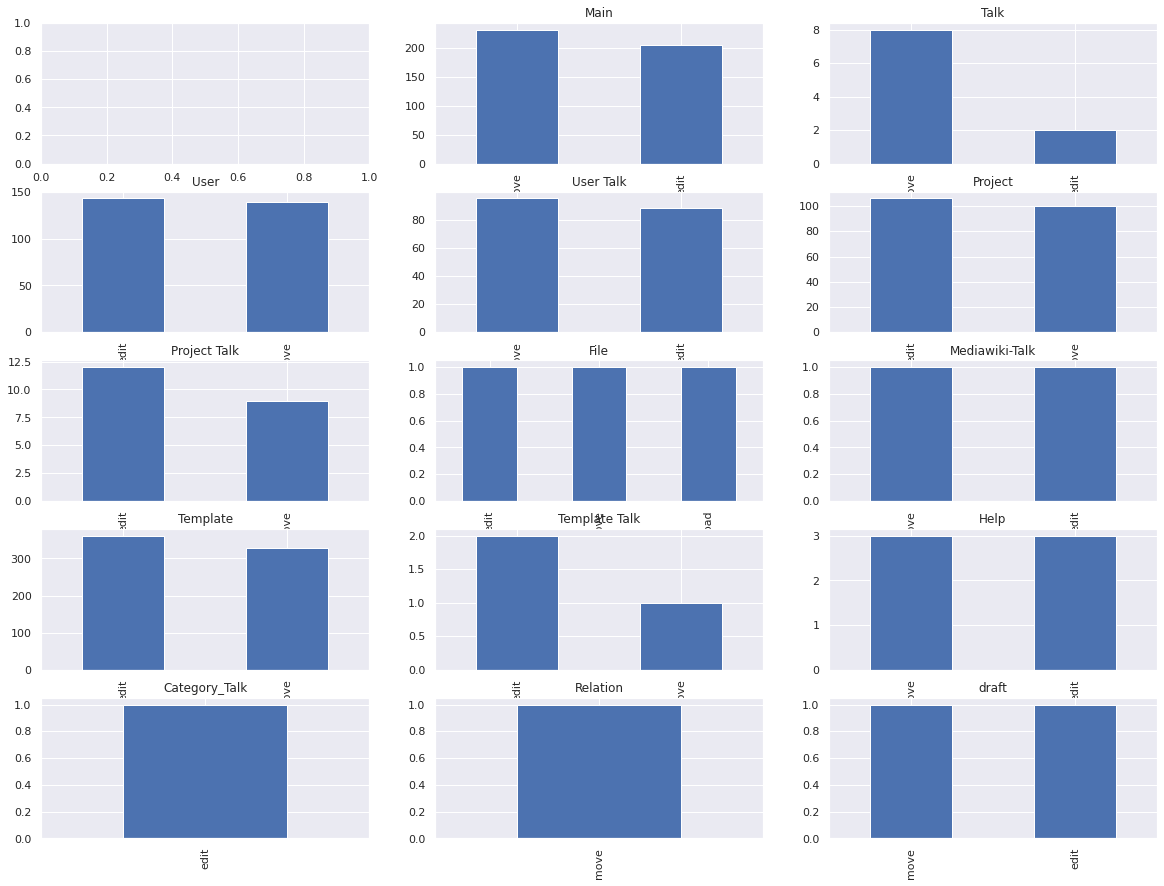

In [51]:
fig, axes = plt.subplots(5,3, figsize=(20,15))

unique= np.unique(protection_data.ns)

for i, ax in enumerate(axes.flatten()[1:]):
    value= df[df['ns']==unique[i]]['type'].value_counts()
    value.plot.bar(ax=ax)
    ax.set_title(ns_dict[int(unique[i])])
    ax.set_ylabel('')

plt.show()


#### Now About The Protection types to namesspaces:
* The 'file' namespaces is seen to be having all the protection types. 'Category', 'Relation' are having 'edit' and 'move' respectively. While the rest are having both the 'edit' and 'move' all together

In [52]:
df.fillna(0, inplace= True)
# This is to fill all the missing values with zero for proper modelling

In [53]:
columns= ['missing', 'title', 'contentmodel', 'pagelanguage', 'pagelanguagehtmlcode', 'pagelanguagedir', 'touched', 'restrictiontypes', 'redirect', 'new', 'type', 'level', 'expiry', 'source' ]

for col in columns:
    le= LabelEncoder()
    df[col]= le.fit_transform(df[col].astype(str))
    
# Label encoder is for  transforming categorical data to numerical data. It is then changed to string because Label Encoder does not accept a mix of int and str     

In [54]:
df.shape

(1916, 21)

### Predictive Model
TODO: Train and evaluate a predictive model on the data you gathered for the above descriptive statistics. Describe what you learned from the model or how it would be useful.

In [55]:
# imports
from sklearn.preprocessing import MinMaxScaler #for data scaling in order to normalize them
from sklearn.model_selection import train_test_split #for spliting data into training and testing data
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report   #for checking accuracy
from sklearn.linear_model import LogisticRegression #A classification and regression algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


In [56]:
X= df.drop(['type', 'new', 'source'], axis= 1) #The predicting variables
y= df['type'] #The target variabl 

In [57]:
# TODO: preprocess data
scaler= MinMaxScaler() #for normalizing data
X= scaler.fit_transform(X) #fitting the scaler

In [58]:
train_x, val_x, train_y, val_y= train_test_split(X, y, test_size= 0.2, random_state= 0)
#splitting into train data and test data

### Logistic Regression Algorithm

In [59]:
# TODO: train model
lr= LogisticRegression()
lr.fit(train_x, train_y)
pred= lr.predict(val_x) #making predictions using the validaton data
print('LE ACC SCORE:', accuracy_score(pred, val_y)) #calculating model accuracy
print('LE Class Report:', classification_report(pred, val_y)) #Checking report of the model performance

LE ACC SCORE: 0.6015625
LE Class Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.61      0.61      0.61       198
           2       0.58      0.58      0.58       183

    accuracy                           0.60       384
   macro avg       0.73      0.73      0.73       384
weighted avg       0.60      0.60      0.60       384



/srv/paws/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Support Vector Machine Algorithm

In [60]:
svm= SVC( probability= True)
svm.fit(train_x, train_y)
preds= svm.predict(val_x)
print('SVM ACC SCORE:', accuracy_score(preds, val_y)) #calculating model accuracy
print('SVM Class Report:', classification_report(preds, val_y)) #Checking report of the model performance

SVM ACC SCORE: 0.6145833333333334
SVM Class Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.63      0.62      0.63       201
           2       0.59      0.60      0.59       180

    accuracy                           0.61       384
   macro avg       0.74      0.74      0.74       384
weighted avg       0.62      0.61      0.61       384



### Voting Classifier Algorithm

In [61]:
voting= VotingClassifier(estimators= [('lr', lr), ('svm', svm)], weights=[1,3], voting= 'hard')

In [62]:
voting.fit(train_x, train_y)
predi= voting.predict(val_x)
print('VOTING ACC SCORE:', accuracy_score(val_y, predi)) #calculating model accuracy
print('Voting Class Report:', classification_report(predi, val_y))  #Checking report of the model performance

/srv/paws/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VOTING ACC SCORE: 0.6145833333333334
Voting Class Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.63      0.62      0.63       201
           2       0.59      0.60      0.59       180

    accuracy                           0.61       384
   macro avg       0.74      0.74      0.74       384
weighted avg       0.62      0.61      0.61       384



In [63]:
from sklearn.feature_selection import RFE
# imported for selecting best features

In [64]:
predictors= train_x
selector= RFE(lr, n_features_to_select= 1)
selector= selector.fit(predictors, train_y) #Fitting data on the feature selector model

/srv/paws/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/srv/paws/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  

In [65]:
order= selector.ranking_
order #This shows the data order of importance 

array([10, 11,  5,  4,  8,  7,  6, 12, 16, 13,  2, 18, 14,  9, 15, 17,  3,
        1])

In [66]:
feature_ranks= []
for i in order:
    feature_ranks.append(f"{i}. {df.columns[i]}")
feature_ranks
#combining each order of importance in respect to the data columns

['10. restrictiontypes',
 '11. watchers',
 '5. pagelanguagehtmlcode',
 '4. pagelanguage',
 '8. lastrevid',
 '7. touched',
 '6. pagelanguagedir',
 '12. visitingwatchers',
 '16. new',
 '13. talkid',
 '2. title',
 '18. level',
 '14. redirect',
 '9. length',
 '15. subjectid',
 '17. type',
 '3. contentmodel',
 '1. ns']

* 'NS', 'title', 'contentmodel', 'pagelanguage', 'pagelanguagehtmlcode' are the most important features to make our prediction
* Feature importance is mainly for us to know the predictors with the best effect o our outcome variable. This is to prevent the model from learning from noise 

In [67]:
#from sklearn.feature_selection import SelectFromModel
#smf= SelectFromModel(lr, threshold= np.inf, max_features= 10)
#smf.fit(train_x, train_y)
#feature_idx= smf.get_support()
#feature_names= df.columns[feature_idx]
#feature_names

In [68]:
# TODO: evaluate model


### Future Analyses
TODO: Describe any additional analyses you can think of that would be interesting (and why) -- even if you are not sure how to do them.

#### This marks the end of the notebook but more things can still be done to improve the accuracy of our model.
#### More data can still be queried from the revision endpoint, contribution page as well.
#### There is always this assumption that'The more the data, the better the performance of the model', which implies that after querying more data from the two named above pages, then, the accuracy of our mmodel will surely improve
#### More predictions can also be doone to predict if a page is protected or not , as this notebook is solely based on the protection types.
#### Further prediction can still be done to predict a page expiry(to a certain period or infinity)